In [11]:
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [12]:
from predict_next_token_in_time_series import *

In [13]:
n0 = 100
paris1 = ParisLawDegradation(length=100, dim=1, C=1e-8)
episodes1 = paris1.generate_episode(x0=np.random.randn(n0)*0.0003+0.0045)  # Initial crack lengths in meters

paris2 = ParisLawDegradation(length=100, dim=1, C=3e-8)
episodes2 = paris2.generate_episode(x0=np.random.randn(n0)*0.0003+0.003)  # Initial crack lengths in meters

paris3 = ParisLawDegradation(length=100, dim=1, C=5e-8)
episodes3 = paris3.generate_episode(x0=np.random.randn(n0)*0.0003+0.0015)  # Initial crack lengths in meters

paris4 = ParisLawDegradation(length=100, dim=1, C=7e-8)
episodes4 = paris4.generate_episode(x0=np.random.randn(n0)*0.0003+0.0007)  # Initial crack lengths in meters

paris5 = ParisLawDegradation(length=100, dim=1, C=8e-8)
episodes5 = paris5.generate_episode(x0=np.random.randn(n0)*0.0003+0.0001)  # Initial crack lengths in meters

episodes = np.concatenate([episodes1, episodes2, episodes3, episodes4, episodes5], axis=0)

#drop invalid values
episodes = episodes[~np.isnan(episodes).any(axis=1)]
episodes = episodes[(episodes<1).any(axis=1)]

episodes.shape

c:\Users\Mohammad\Documents\Python Scripts\projects\degradation-transformer\degradation-transformer\predict_next_token_in_time_series.py:42: RuntimeWarning:

invalid value encountered in sqrt



(466, 101)

In [14]:


# Check default device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Default Device:", device)

Default Device: cpu


In [15]:
print(f"Min: {episodes.min()}")
print(f"Max: {episodes.max()}")

Min: 2.1847621195027244e-06
Max: 0.01787162320923346


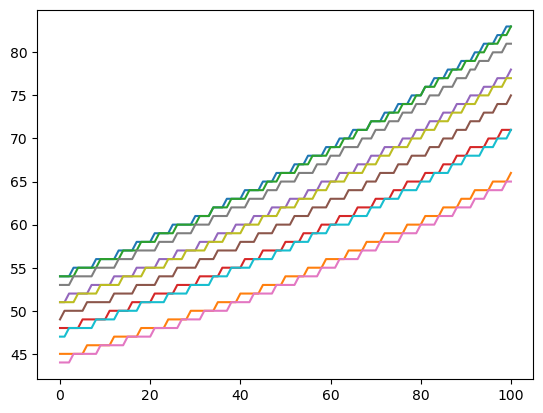

In [16]:
digitized_episodes = digitize_np(episodes, 0, episodes.max()+0.01, 300)
plt.plot(digitized_episodes[:10].T)

In [17]:


# Split episodes into train/test (e.g., 80/20)
n_train = int(0.8 * len(digitized_episodes))
train_episodes = digitized_episodes[:n_train]
test_episodes = digitized_episodes[n_train:]


In [18]:
train_dataset = TimeSeriesDataset(train_episodes)
test_dataset = TimeSeriesDataset(test_episodes)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model = DegradationTransformer(vocab_size=300, context_window=40, 
                               embedding_dim=64, num_heads=4, num_blocks=3)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

In [19]:
len(train_loader), len(test_loader)

(710, 180)

In [20]:
cbs = [ProgressCallback(20)]
learner = Learner(model, optim, loss_func, train_loader, test_loader, cbs)
learner.fit(2)

FigureWidget({
    'data': [{'line': {'color': 'blue'},
              'mode': 'lines',
              'name': 'Training Loss',
              'type': 'scatter',
              'uid': '35bd7c1a-45f0-4cec-8e3f-bbf8e7010cd6',
              'x': array([   0,    1,    2, ..., 1408, 1409, 1410]),
              'xaxis': 'x',
              'y': [22.18461799621582, 22.940067291259766, 17.445573806762695,
                    ..., 0.2891004979610443, 0.1763972043991089,
                    0.06348256766796112],
              'yaxis': 'y'},
             {'line': {'color': 'orange'},
              'mode': 'lines',
              'name': 'Test Loss',
              'type': 'scatter',
              'uid': '96b55989-96d5-48db-9907-fd867b2ade80',
              'x': array([  0,   1,   2, ..., 338, 339, 340]),
              'xaxis': 'x2',
              'y': [0.14520855247974396, 0.34327927231788635, 0.24571187794208527,
                    ..., 0.22096526622772217, 0.2049676477909088,
                    0.20

In [21]:
learner.test_idx

179